In [1]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


0    549
1    342
Name: Survived, dtype: int64


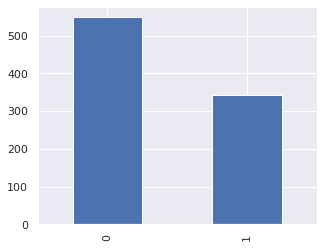

In [3]:
plt.figure(figsize=(5,4))
train['Survived'].value_counts().plot(kind = 'bar')
print(train.Survived.value_counts())

In [4]:
train[train['Pclass']==1]['Survived'].mean()

0.6296296296296297

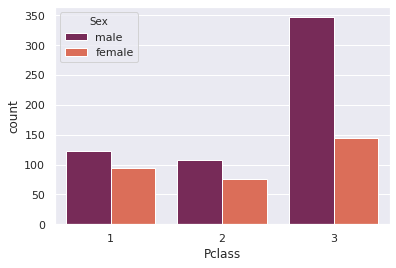

In [5]:
sns.countplot(x='Pclass', hue='Sex', data=train, palette="rocket")

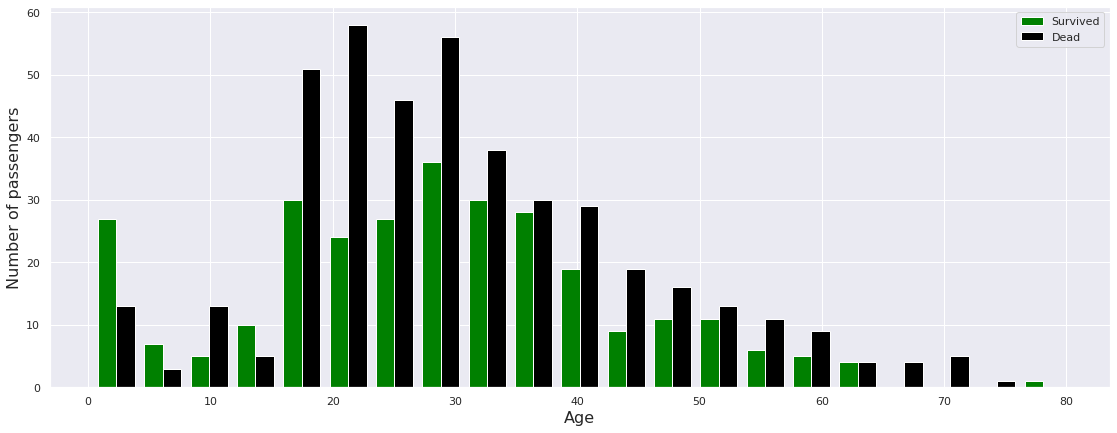

In [6]:
figure = plt.figure(figsize=(19,7))
color = ['green', 'black']
plt.hist([train[train['Survived']==1]['Age'],train[train['Survived']==0]['Age']], 
         bins=21, label=['Survived','Dead'], color=color)
plt.xlabel('Age',size=16)
plt.ylabel('Number of passengers',size=16)
plt.legend()

In [7]:
av_surv = train.groupby('Survived')['Age'].mean()
av_surv.round()

Survived
0    31.0
1    28.0
Name: Age, dtype: float64

In [8]:
pd.crosstab(train['Survived'],train['Pclass'])

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [9]:
train['Title'] = train.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
train.Title.value_counts()                                                                           # Title  #NEW

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Don               1
Lady              1
Sir               1
Ms                1
Mme               1
Capt              1
Jonkheer          1
the Countess      1
Name: Title, dtype: int64

In [10]:
train.Cabin = train.Cabin.fillna('U')                                                                      # Cabin

In [11]:
train['Age'].fillna(train.groupby(['Sex','Pclass','Title'])['Age'].transform('median'),inplace=True)         # Age

In [12]:
train['Pclass'] = train['Pclass'].astype(str)
train['Sex_Pclass'] = train['Sex'].str[0] + '_' + train['Pclass'].str[0]                        #Sex_Pclass  # NEW

In [13]:
train['Family'] = train['SibSp'] + train['Parch']                                                   #Family # NEW

In [14]:
most = train.Embarked.value_counts().index[0]
train.Embarked = train.Embarked.fillna(most)  
train['Fare'] = train.Fare.fillna(train.Fare.median())

In [15]:
test['Title'] = test.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())  # Title
test['Pclass'] = test['Pclass'].astype(str)                                            
test['Sex_Pclass'] = test['Sex'].str[0] + '_' + test['Pclass'].str[0]                   # Sex_Pclass
test['Family'] = test['SibSp'] + test['Parch'] 

In [16]:
test.Fare = test.Fare.fillna(test['Fare'].mean())
test.Cabin = test.Cabin.fillna('U') 
test['Age'].fillna(test.groupby(['Sex','Pclass'])['Age'].transform('median'),inplace=True)
test['Fare'] = test.Fare.fillna(test.Fare.median())

In [17]:
X = train[['Sex_Pclass','Age','Fare','Title','Family']] 
y = train['Survived'] 

In [18]:
X.shape, y.shape

((891, 5), (891,))

In [19]:
Xtrain = train[['Family','Sex_Pclass','Title','Age','Fare']]
ytrain = train['Survived']
Xtest = test

In [20]:
pipeline = make_pipeline(MinMaxScaler(),KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile') )

In [21]:
trans = ColumnTransformer([
    ('scale_bin', pipeline, ['Fare']),
    ('dan_nothing', 'passthrough', ['Family']),
    ('dan_onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Sex_Pclass','Title']),
    ('d_bins', KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='uniform'), ['Age']),
])

In [22]:
trans.fit(Xtrain)
X_tr = trans.transform(Xtrain)  
X_tr.shape

(891, 183)

In [23]:
model = LogisticRegression(max_iter=1000)
model.fit(X_tr, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
X_ts = trans.transform(Xtest)
X_ts.shape

/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


(418, 183)

In [25]:
ypred = model.predict(X_ts)

In [26]:
passengerId = test.index
predict = pd.DataFrame( {'PassengerId': passengerId, 'Survived': ypred} )

In [27]:
predict.to_csv('titanic_pred.csv', index=False)